# <h1 style="color:#AED6F1 ; font-weight: bold; font-style: italic;">Getting Started</h1>

The basis of all of our analysis starts with the binaural signal, so we begin by importing the `Binaural` class. We'll also load up and examine our analysis settings.

In [16]:
# imports
import json
import pandas as pd
from pathlib import Path

# Set display options
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_rows', None)     # Show all rows
pd.set_option('display.width', None)        # Set width to fit the entire DataFrame

from soundscapy import Binaural
from soundscapy import AnalysisSettings
from soundscapy.analysis.binaural import prep_multiindex_df, add_results, process_all_metrics


Set up where the data is located. In this case, we'll use the sample recordings located under the `data` folder.

In [17]:
# May need to adjust for your system
wav_folder = Path().cwd().joinpath("data")

Ensuring that Soundscapy knows exactly how loud your recordings were onsite is crucial to getting correct answers. If you used equipment such as the Head Acoustics SqoBold, and were careful about how the recordings are exported to .wav, then they may already be correctly adjusted (as ours are here). However its best to be safe and calibrate each signal to their real-world dB level. To do this, we load in a .json that contains the per-channel correct dB $L_{eq}$ level.

In [18]:
levels = wav_folder.joinpath("Levels.json")

with open("data/Levels.json") as f:
    levels= json.load(f)

# Look at the first five sets of levels
list(levels.items())[:5]
#or
#list(levels.items())

[('CT101', {'Left': 79.0, 'Right': 79.72}),
 ('CT102', {'Left': 79.35, 'Right': 79.88}),
 ('CT103', {'Left': 76.25, 'Right': 76.41}),
 ('CT104', {'Left': 79.9, 'Right': 79.93}),
 ('CT107', {'Left': 78.21, 'Right': 78.47})]

# <h1 style="color:#AED6F1 ; font-weight: bold; font-style: italic;">Prepping the Results Dataframe</h1>

The easiest way to organise and add the new data as it is processed is to prepare a dataframe ahead of time. We've provided a small function to convert a dictionary of calibration levels (`level`) into the properly formatted dataframe.

In [19]:
df = prep_multiindex_df(levels, incl_metric=True)
df.head()

Leq
Recording Channel       
CT101     Left     79.00
          Right    79.72
CT102     Left     79.35
          Right    79.88
CT103     Left     76.25

# <h1 style="color:#AED6F1 ; font-weight: bold; font-style: italic;">Load in a Binaural Recording</h1>

Load in a binaural wav signal. We can use the `plot` function provided by the `acoustics.Signal` super-class.

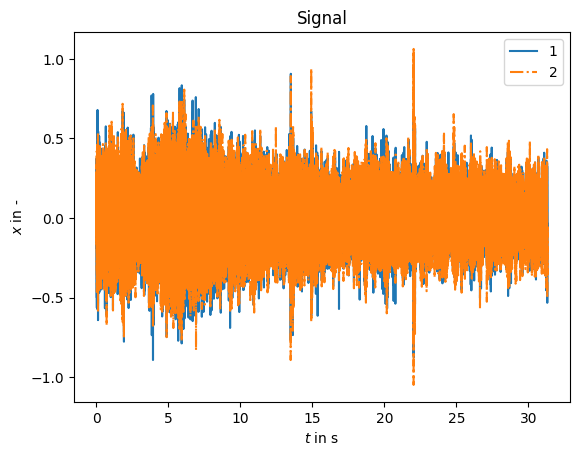

In [20]:
binaural_wav = wav_folder.joinpath("CT107.wav") #we can load and Binaural Recording 
b = Binaural.from_wav(binaural_wav)
b.plot();

To ensure that the dB level is correct, and therefore any other metrics are correct, we start by calibrating the signal to precalculated levels.

In [21]:
decibel = (levels[b.recording]["Left"], levels[b.recording]["Right"])
print(f"Calibration levels: {decibel}")
b.calibrate_to(decibel, inplace=True)

Calibration levels: (78.21, 78.47)


Signal([[ 0.25029334  0.24416909  0.23869655 ... -0.04915015 -0.05414756
  -0.05422246]
 [ 0.196869    0.1967845   0.19533505 ... -0.07049724 -0.0626168
  -0.0548369 ]])

Now, check it by comparing it to what we already knew were the correct levels:

In [22]:
print(f"Predefined levels: {levels[b.recording]}")
print(f"Calculated Levels: {b.pyacoustics_metric('Leq', statistics=['avg'], as_df=False)}")

Predefined levels: {'Left': 78.21, 'Right': 78.47}
Calculated Levels: {'Left': {'Leq': 78.2157873380417}, 'Right': {'Leq': 78.47550130484643}}


# <h1 style="color:#AED6F1 ; font-weight: bold; font-style: italic;">Calculating Acoustic Metrics</h1>

This brings us to how to calculate any of the many metrics available(Python Acoustics, scikit-maad, MoSQITo).

<h2 style="color:#FFA500 ; font-weight: bold; font-style: italic;">1) Python Acoustics</h2>

$L_{Aeq}$, $L_{Ceq}$, $L_{Zeq}$, SEL, and all associated statistics ($L_5$ through $L_{95}$, $L_{max}$ and $L_{min}$, as well as [kurtosis](https://acousticstoday.org/wp-content/uploads/2020/12/Kurtosis-A-New-Tool-for-Noise-Analysis-Wei-Qiu-William-J.-Murphy-and-Alice-Suter.pdf) and skewness can be calculated.

Since the $L_{Aeq}$ calc is provided by the Python Acoustics library, we'll be calling `pyacoustic_metric`. Then, we need to tell it what particular metric we want, what stats to calculate as well, what to label it, and what format to return the results in.

In [23]:
metric = "LAeq"
stats = (5, 10, 50, 90, 95, 'min', 'max', 'kurt', 'skew')
label = "LAeq"
b.pyacoustics_metric(metric, stats, label, as_df=False)

{'Left': {'LAeq_5': 72.24842002576351,
  'LAeq_10': 71.39503693700188,
  'LAeq_50': 66.19903970844183,
  'LAeq_90': 62.448782241986784,
  'LAeq_95': 61.53306718159582,
  'LAeq_min': 60.039913138589725,
  'LAeq_max': 76.17793870253844,
  'LAeq_kurt': -0.5353112063021412,
  'LAeq_skew': 0.38680341837577864},
 'Right': {'LAeq_5': 71.15432853551225,
  'LAeq_10': 69.52077796094561,
  'LAeq_50': 65.56753038363209,
  'LAeq_90': 62.73709662215419,
  'LAeq_95': 62.105324507324426,
  'LAeq_min': 59.427035007231204,
  'LAeq_max': 73.69993148345495,
  'LAeq_kurt': -0.2291520124218982,
  'LAeq_skew': 0.4907341505025647}}

If we want, we can get the results back as a pandas DataFrame instead:

In [24]:
b.pyacoustics_metric(metric, stats, label, as_df=True)

LAeq_5    LAeq_10   LAeq_50    LAeq_90    LAeq_95  \
Recording Channel                                                         
CT107     Left     72.248420  71.395037  66.19904  62.448782  61.533067   
          Right    71.154329  69.520778  65.56753  62.737097  62.105325   

                    LAeq_min   LAeq_max  LAeq_kurt  LAeq_skew  
Recording Channel                                              
CT107     Left     60.039913  76.177939  -0.535311   0.386803  
          Right    59.427035  73.699931  -0.229152   0.490734

And we can easily do the same for the C-weighting level, Z-weighting level & SEL:

In [25]:
b.pyacoustics_metric("LCeq", stats, as_df=True)

LCeq_5    LCeq_10    LCeq_50    LCeq_90    LCeq_95  \
Recording Channel                                                          
CT107     Left     79.242247  78.680350  75.113815  72.328403  71.518266   
          Right    79.551775  78.854831  75.249339  72.684648  72.032466   

                    LCeq_min   LCeq_max  LCeq_kurt  LCeq_skew  
Recording Channel                                              
CT107     Left     70.240559  81.788550  -0.472528   0.280531  
          Right    70.161490  82.722557  -0.258482   0.382297

In [26]:
b.pyacoustics_metric("LZeq", stats, as_df=True)

LZeq_5    LZeq_10    LZeq_50    LZeq_90    LZeq_95  \
Recording Channel                                                          
CT107     Left     81.496859  80.480254  77.731949  74.486408  73.514358   
          Right    81.463682  80.680323  77.984310  74.911419  74.325250   

                    LZeq_min   LZeq_max  LZeq_kurt  LZeq_skew  
Recording Channel                                              
CT107     Left     71.178348  82.710189  -0.256629  -0.216762  
          Right    72.526641  83.399769  -0.407596  -0.065666

In [27]:
b.pyacoustics_metric("SEL", stats, as_df=True)

SEL
Recording Channel                   
CT107     Left     93.17363454672746
          Right    93.43334994170716

By default, the metrics will be calculated for both channels. But you may want only a single channel. This can be set with the `channel` option.

In [28]:
b.pyacoustics_metric("LZeq", channel="Left")

,LZeq,LZeq_5,LZeq_10,LZeq_50,LZeq_90,LZeq_95,LZeq_max,LZeq_min,LZeq_kurt,LZeq_skew
CT107,78.215787,81.496859,80.480254,77.731949,74.486408,73.514358,82.710189,71.178348,-0.256629,-0.216762



<h2 style="color:#FFA500 ; font-weight: bold; font-style: italic;">2) scikit-maad</h2>

So far we have only implemented the combined `all_temporal_alpha_indices` and `all_spectral_alpha_indices` from `scikit-maad`; calculating them individually is not yet supported. `all_temporal_alpha_indices` comprises 16 temporal domain acoustic indices, such as temporal signal-to-noise-ratio, temporal entropy, temporal events. `all_spectral_alpha_indices` comprises 19 spectral domain acoustic indices, such as Bioacoustic Index, Acoustic Diversity Index, NDSI, Acoustic Evenness Index.

In [29]:
b.maad_metric("all_spectral_alpha_indices", verbose=True)

 - Calculating scikit-maad all_spectral_alpha_indices


MEANf      VARf      SKEWf       KURTf  NBPEAKS  \
Recording Channel                                                       
CT107     Left     0.001479  0.000036   9.825045  122.492452       37   
          Right    0.001326  0.000038  10.339752  132.480186       20   

                        LEQf       ENRf       BGNf      SNRf        Hf  \
Recording Channel                                                        
CT107     Left     75.948564 -17.051436 -19.651605  2.600169  0.348846   
          Right    76.043214 -16.956786 -19.346480  2.389694  0.322173   

                        EAS       ECU       ECV       EPS   EPS_KURT  \
Recording Channel                                                      
CT107     Left     0.036546  0.193313  0.139967  0.062280  43.707622   
          Right    0.014564  0.153080  0.120603  0.047377  16.901112   

                   EPS_SKEW         ACI      NDSI       rBA  AnthroEnergy  \
Recording Channel                                                           
CT107     Left     4.938425  340.551819 -0.926289  0.038266     55.668964   
          Right    2.992209  324.158752 -0.953544  0.023780     57.110458   

                   BioEnergy         BI        ROU       ADI       AEI  \
Recording Channel                                                        
CT107     Left      2.130217  41.508781  55.197697  1.552340  0.633157   
          Right     1.358111  41.767443  56.448845  1.349227  0.693300   

                        LFC       MFC       HFC  ACTspFract  ACTspCount  \
Recording Channel                                                         
CT107     Left     0.209819  0.237210  0.249068    0.239777  703.744141   
          Right    0.198111  0.200967  0.237095    0.222890  654.181641   

                   ACTspMean  EVNspFract  EVNspMean  EVNspCount      TFSD  \
Recording Channel                                                           
CT107     Left     15.935174    0.092731   0.069114    1.342087  0.189200   
          Right    11.735473    0.074912   0.063990    1.148559  0.164626   

                   H_Havrda   H_Renyi  H_pairedShannon      H_gamma  \
Recording Channel                                                     
CT107     Left     0.306238  1.254894         3.044224  1338.067243   
          Right    0.301908  1.180761         2.863630   875.440276   

                   H_GiniSimpson      RAOQ       AGI  ROItotal  ROIcover  
Recording Channel                                                         
CT107     Left          0.770212  0.014416  1.821037        31  3.092858  
          Right         0.747898  0.008257  1.578739        45  2.396588

In [30]:
b.maad_metric("all_temporal_alpha_indices", verbose=True)

 - Calculating scikit-maad all_temporal_alpha_indices


ZCR     MEANt      VARt     SKEWt     KURTt  \
Recording Channel                                                       
CT107     Left     704.498042  0.000011  0.026524 -0.042622  3.279072   
          Right    579.774779 -0.000011  0.028159 -0.024423  3.214235   

                        LEQt       BGNt      SNRt       MED        Ht  \
Recording Channel                                                       
CT107     Left     77.258902 -10.650244  1.133523  0.293419  0.966822   
          Right    77.521892 -10.620388  1.054663  0.294429  0.969091   

                   ACTtFraction  ACTtCount  ACTtMean  EVNtFraction  EVNtMean  \
Recording Channel                                                              
CT107     Left         0.171662        504  4.940459      0.130450  0.035836   
          Right        0.164850        484  4.795009      0.120572  0.032835   

                   EVNtCount  
Recording Channel             
CT107     Left      3.641397  
          Right     3.673339


<h1 style="color:#FFA500 ; font-weight: bold; font-style: italic;">3) MoSQITo</h1>

MoSQITo is very exciting as it is one of the first completely free and open-source libraries for calculating psychoacoustic features.

Let's try out calculating the psychoacoustic Loudness, Sharpness, and Roughness.

We start by defining many of the same options, but with two new ones. The first is our `func_args` to pass to `MoSQITo`. Since our test recording was collected in a public park, we need to select the correct field type: free or diffuse, and pass that to MoSQITo.

The second new argument is `parallel`. This just tells Soundscapy whether to try to calculate the Left and Right channels simultaneously to speed up processing.

In [38]:
metric = "loudness_zwtv"
stats = (5, 50, 'avg', 'max')
func_args = {
    'field_type': 'free'
}

b.mosqito_metric(metric, statistics=stats, as_df=True, parallel=True, verbose=True, func_args=func_args)

 - Calculating MoSQITo metric: loudness_zwtv


N_5       N_50      N_avg      N_max
Recording Channel                                            
CT107     Left     29.272874  19.600586  20.735952  36.678760
          Right    26.464431  18.985188  19.748700  32.968039

`sharpness_din_from_loudness` is a bit of a special case to keep in mind. It can drastically speed up the processing time since it calculates the Sharpness values from pre-calculated Loudness results. If you are planning to do both analyses, I highly suggest using it. Soundscapy will handle it behind the scenes to make sure it doesn't accidentally calculate the Loudness values twice if you've asked for both of them. Let's try it out.

In [39]:
b.mosqito_metric("sharpness_din_from_loudness", stats, as_df=True, parallel=True, verbose=True, func_args=func_args)

 - Calculating MoSQITo metrics: `sharpness_din` from `loudness_zwtv`


N_5       N_50      N_avg      N_max       S_5  \
Recording Channel                                                         
CT107     Left     29.272874  19.600586  20.735952  36.678760  1.486110   
          Right    26.464431  18.985188  19.748700  32.968039  1.357829   

                       S_50     S_avg      S_max  
Recording Channel                                 
CT107     Left     1.187770  1.215446  19.104348  
          Right    1.142107  1.160933  19.097565

In [43]:
b.mosqito_metric("roughness_dw", stats, as_df=True, verbose=True, func_args=func_args)

 - Calculating MoSQITo metric: roughness_dw


R_5      R_50     R_avg     R_max
Recording Channel                                        
CT107     Left     0.144713  0.053606  0.072665  1.106715
          Right    0.237170  0.053157  0.095495  2.529605

# <h1 style="color:#AED6F1 ; font-weight: bold; font-style: italic;">Defining Analysis Settings</h1>

Soundscapy provides the ability to predefine your analysis settings. These are defined in a separate `.yaml` file and are managed by Soundscapy using the `AnalysisSettings` class. These settings can then be passed to any of the analysis functions, rather than separately defining your settings as we did above. This will be particularly useful when performing our batch processing on an entire folder of wav recordings later.

Soundscapy provides a set of default settings which can be easily loaded in:

In [31]:
analysis_settings = AnalysisSettings.default()
analysis_settings

{'PythonAcoustics': {'LAeq': {'run': True,
   'main': 'avg',
   'statistics': [5, 10, 50, 90, 95, 'min', 'max', 'kurt', 'skew'],
   'channel': ['Left', 'Right'],
   'label': 'LAeq',
   'func_args': {'time': 0.125, 'method': 'average'}},
  'LZeq': {'run': True,
   'main': 'avg',
   'statistics': [5, 10, 50, 90, 95, 'min', 'max', 'kurt', 'skew'],
   'channel': ['Left', 'Right'],
   'label': 'LZeq',
   'func_args': {'time': 0.125, 'method': 'average'}},
  'LCeq': {'run': True,
   'main': 'avg',
   'statistics': [5, 10, 50, 90, 95, 'min', 'max', 'kurt', 'skew'],
   'channel': ['Left', 'Right'],
   'label': 'LCeq',
   'func_args': {'time': 0.125, 'method': 'average'}},
  'SEL': {'run': True,
   'main': [],
   'statistics': [],
   'channel': ['Left', 'Right'],
   'label': 'SEL'}},
 'MoSQITo': {'loudness_zwtv': {'run': False,
   'main': 5,
   'statistics': [10, 50, 90, 95, 'min', 'max', 'kurt', 'skew', 'avg'],
   'channel': ['Left', 'Right'],
   'label': 'N',
   'parallel': True,
   'func_arg

However, in your own analysis you'll probably want to define your own options and load that in. We'll show how this is done using the ' example_settings.yaml ' file.

Let's try loading in the `example_settings.yaml` file and see how `AnalysisSettings` handles it.

In [32]:
ex_settings = AnalysisSettings.from_yaml(Path("example_settings.yaml"))
ex_settings

{'PythonAcoustics': {'LAeq': {'run': True,
   'main': 'avg',
   'statistics': [5, 10, 50, 90, 95, 'min', 'max', 'kurt', 'skew'],
   'channel': ['Left', 'Right'],
   'label': 'LAeq',
   'func_args': {'time': 0.125, 'method': 'average'}},
  'LZeq': {'run': True,
   'main': 'avg',
   'statistics': [5, 10, 50, 90, 95, 'min', 'max', 'kurt', 'skew'],
   'channel': ['Left', 'Right'],
   'label': 'LZeq',
   'func_args': {'time': 0.125, 'method': 'average'}},
  'LCeq': {'run': True,
   'main': 'avg',
   'statistics': [5, 10, 50, 90, 95, 'min', 'max', 'kurt', 'skew'],
   'channel': ['Left', 'Right'],
   'label': 'LCeq',
   'func_args': {'time': 0.125, 'method': 'average'}},
  'SEL': {'run': True,
   'main': [],
   'statistics': [],
   'channel': ['Left', 'Right'],
   'label': 'SEL'}},
 'MoSQITo': {'loudness_zwtv': {'run': False,
   'main': 5,
   'statistics': [10, 50, 90, 95, 'min', 'max', 'kurt', 'skew', 'avg'],
   'channel': ['Left', 'Right'],
   'label': 'N',
   'parallel': True,
   'func_arg

You can easily reload the settings `.yaml` after changing it:

In [33]:
ex_settings = ex_settings.reload()

# <h1 style="color:#AED6F1 ; font-weight: bold; font-style: italic;">Running a Single Metric with Predefined Settings</h1>

Now, with our settings loaded, we process a recording using those settings:

In [34]:
b.pyacoustics_metric("LAeq", analysis_settings=ex_settings)

LAeq     LAeq_5    LAeq_10   LAeq_50    LAeq_90  \
Recording Channel                                                        
CT107     Left     68.04434  72.248420  71.395037  66.19904  62.448782   
          Right    66.95764  71.154329  69.520778  65.56753  62.737097   

                     LAeq_95   LAeq_min   LAeq_max  LAeq_kurt  LAeq_skew  
Recording Channel                                                         
CT107     Left     61.533067  60.039913  76.177939  -0.535311   0.386803  
          Right    62.105325  59.427035  73.699931  -0.229152   0.490734

In [35]:
b.pyacoustics_metric("LCeq", analysis_settings=ex_settings)

LCeq     LCeq_5    LCeq_10    LCeq_50    LCeq_90  \
Recording Channel                                                          
CT107     Left     76.091611  79.242247  78.680350  75.113815  72.328403   
          Right    76.175086  79.551775  78.854831  75.249339  72.684648   

                     LCeq_95   LCeq_min   LCeq_max  LCeq_kurt  LCeq_skew  
Recording Channel                                                         
CT107     Left     71.518266  70.240559  81.788550  -0.472528   0.280531  
          Right    72.032466  70.161490  82.722557  -0.258482   0.382297

In [36]:
b.pyacoustics_metric("LZeq", analysis_settings=ex_settings)

LZeq     LZeq_5    LZeq_10    LZeq_50    LZeq_90  \
Recording Channel                                                          
CT107     Left     78.215787  81.496859  80.480254  77.731949  74.486408   
          Right    78.475501  81.463682  80.680323  77.984310  74.911419   

                     LZeq_95   LZeq_min   LZeq_max  LZeq_kurt  LZeq_skew  
Recording Channel                                                         
CT107     Left     73.514358  71.178348  82.710189  -0.256629  -0.216762  
          Right    74.325250  72.526641  83.399769  -0.407596  -0.065666

In [37]:
b.pyacoustics_metric("SEL", analysis_settings=ex_settings)

SEL
Recording Channel                   
CT107     Left     93.17363454672746
          Right    93.43334994170716

But this is just the start of what makes the analysis settings so useful.


# <h1 style="color:#AED6F1 ; font-weight: bold; font-style: italic;">Processing All the Metrics at Once, Using Predefined Settings</h1>

Since we can define the settings for all the metrics, and specify which metrics we want to run, we can process all of our desired metrics at once. `process_all_metrics()` let's us do this with just a single line of code.

In [38]:
b.process_all_metrics(ex_settings, verbose=True)

Processing CT107
 - Calculating Python Acoustics metrics: LAeq
 - Calculating Python Acoustics metrics: LZeq
 - Calculating Python Acoustics metrics: LCeq
 - Calculating Python Acoustics metrics: SEL
 - Calculating scikit-maad all_temporal_alpha_indices
 - Calculating scikit-maad all_spectral_alpha_indices


LAeq     LAeq_5    LAeq_10   LAeq_50    LAeq_90  \
Recording Channel                                                        
CT107     Left     68.04434  72.248420  71.395037  66.19904  62.448782   
          Right    66.95764  71.154329  69.520778  65.56753  62.737097   

                     LAeq_95   LAeq_min   LAeq_max  LAeq_kurt  LAeq_skew  \
Recording Channel                                                          
CT107     Left     61.533067  60.039913  76.177939  -0.535311   0.386803   
          Right    62.105325  59.427035  73.699931  -0.229152   0.490734   

                        LZeq     LZeq_5    LZeq_10    LZeq_50    LZeq_90  \
Recording Channel                                                          
CT107     Left     78.215787  81.496859  80.480254  77.731949  74.486408   
          Right    78.475501  81.463682  80.680323  77.984310  74.911419   

                     LZeq_95   LZeq_min   LZeq_max  LZeq_kurt  LZeq_skew  \
Recording Channel                                                          
CT107     Left     73.514358  71.178348  82.710189  -0.256629  -0.216762   
          Right    74.325250  72.526641  83.399769  -0.407596  -0.065666   

                        LCeq     LCeq_5    LCeq_10    LCeq_50    LCeq_90  \
Recording Channel                                                          
CT107     Left     76.091611  79.242247  78.680350  75.113815  72.328403   
          Right    76.175086  79.551775  78.854831  75.249339  72.684648   

                     LCeq_95   LCeq_min   LCeq_max  LCeq_kurt  LCeq_skew  \
Recording Channel                                                          
CT107     Left     71.518266  70.240559  81.788550  -0.472528   0.280531   
          Right    72.032466  70.161490  82.722557  -0.258482   0.382297   

                                 SEL         ZCR     MEANt      VARt  \
Recording Channel                                                      
CT107     Left     93.17363454672746  704.498042  0.000011  0.026524   
          Right    93.43334994170716  579.774779 -0.000011  0.028159   

                      SKEWt     KURTt       LEQt       BGNt      SNRt  \
Recording Channel                                                       
CT107     Left    -0.042622  3.279072  77.258902 -10.650244  1.133523   
          Right   -0.024423  3.214235  77.521892 -10.620388  1.054663   

                        MED        Ht  ACTtFraction  ACTtCount  ACTtMean  \
Recording Channel                                                          
CT107     Left     0.293419  0.966822      0.171662        504  4.940459   
          Right    0.294429  0.969091      0.164850        484  4.795009   

                   EVNtFraction  EVNtMean  EVNtCount     MEANf      VARf  \
Recording Channel                                                          
CT107     Left         0.130450  0.035836   3.641397  0.001479  0.000036   
          Right        0.120572  0.032835   3.673339  0.001326  0.000038   

                       SKEWf       KURTf  NBPEAKS       LEQf       ENRf  \
Recording Channel                                                         
CT107     Left      9.825045  122.492452       37  75.948564 -17.051436   
          Right    10.339752  132.480186       20  76.043214 -16.956786   

                        BGNf      SNRf        Hf       EAS       ECU  \
Recording Channel                                                      
CT107     Left    -19.651605  2.600169  0.348846  0.036546  0.193313   
          Right   -19.346480  2.389694  0.322173  0.014564  0.153080   

                        ECV       EPS   EPS_KURT  EPS_SKEW         ACI  \
Recording Channel                                                        
CT107     Left     0.139967  0.062280  43.707622  4.938425  340.551819   
          Right    0.120603  0.047377  16.901112  2.992209  324.158752   

                       NDSI       rBA  AnthroEnergy  BioEnergy         BI  \
Recording Channel                            

# <h1 style="color:#AED6F1 ; font-weight: bold; font-style: italic;">Batch Processing a Bunch of Recordings</h1>

The final step is to run all of these metrics on a whole bunch of wav recordings all at once. In the Soundscape Indices (SSID) project for which this package was developed, we use this data to train machine learning models, so it's necessary to process a large number of recordings. Using the predefined analysis settings, we can loop through an entire folder, add it all to the results dataframe and come away with a single spreadsheet of all of the metrics needed.

To start, we'll demonstrate this using a normal `for` loop. The `for` loop will process one recording at a time and add it to our results dataframe. For the demonstration, we'll reload all of the variables needed and use the default analysis settings to run all of the metrics and time it.

In [41]:
import time # Just for timing
from tqdm import tqdm

wav_folder = Path().cwd().joinpath("data")
levels = wav_folder.joinpath("Levels.json")
with open(levels) as f:
    levels = json.load(f)
df = prep_multiindex_df(levels, incl_metric=False)

analysis_settings = AnalysisSettings.default()
analysis_settings["MoSQITo"]["sharpness_din_from_loudness"]["run"] = False
analysis_settings["MoSQITo"]["sharpness_din_perseg"]["run"] = False
analysis_settings["MoSQITo"]["roughness_dw"]["run"] = False

begin = time.perf_counter() # Start timer

# Loop through each wav file in the folder
for wav in (pbar := tqdm(list(wav_folder.glob("*.wav")))):
    recording = wav.stem
    pbar.set_description(f"Processing {recording}")
    decibel = tuple(levels[recording].values())
    b = Binaural.from_wav(wav, calibrate_to=decibel)
    df = add_results(df, b.process_all_metrics(analysis_settings, verbose=False, parallel=True)) # Process all metrics and add to results df

end = time.perf_counter() # Stop timer

Processing CT101:   0%|          | 0/8 [00:00<?, ?it/s]

Processing CT110: 100%|██████████| 8/8 [01:02<00:00,  7.84s/it]


In [42]:
print("Run on This Desktop")
print(f"Time taken (using for loop): {end-begin: .2f} seconds ({(end-begin)/60: .2f} minutes)")
df

Run on This Desktop
Time taken (using for loop):  62.74 seconds ( 1.05 minutes)


LAeq     LAeq_5    LAeq_10    LAeq_50    LAeq_90  \
Recording Channel                                                          
CT101     Left     68.875703  72.257301  71.154342  68.113339  63.375091   
          Right    69.953333  73.623236  72.578152  68.495399  64.533057   
CT102     Left     70.613447  74.541317  73.322597  69.297264  65.074481   
          Right    70.491840  75.681356  73.055797  69.131814  64.975452   
CT103     Left     66.330006  69.010487  68.241612  65.579475  63.680847   
          Right    66.320960  69.247212  68.344756  65.717681  64.145147   
CT104     Left     72.385734  76.823628  75.846019  70.883017  68.178606   
          Right    70.661228  75.007596  72.920992  69.693243  67.615660   
CT107     Left     68.044340  72.248420  71.395037  66.199040  62.448782   
          Right    66.957640  71.154329  69.520778  65.567530  62.737097   
CT108     Left     70.589507  74.558756  73.843937  69.525786  64.824693   
          Right    70.112106  73.867805  73.206158  69.500252  63.767889   
CT109     Left     69.629802  73.858804  72.535949  68.088413  65.395855   
          Right    68.140737  71.302562  70.788590  67.176560  64.900719   
CT110     Left     68.696864  73.688152  73.278617  66.395310  61.541000   
          Right    68.086205  72.842216  72.233530  65.950830  60.897040   

                     LAeq_95   LAeq_min   LAeq_max  LAeq_kurt  LAeq_skew  \
Recording Channel                                                          
CT101     Left     62.366533  60.560166  77.382651   0.272011  -0.013877   
          Right    63.097659  60.520566  78.708783   0.473515   0.140450   
CT102     Left     64.561974  63.337182  78.922344   0.270694   0.530142   
          Right    64.209771  63.114758  81.634943   0.648596   0.601576   
CT103     Left     63.194765  62.103353  74.234566   2.236365   1.127518   
          Right    63.852638  62.685126  72.061583   1.008471   0.981831   
CT104     Left     67.906102  67.060970  78.252226  -0.551273   0.581452   
          Right    67.257368  65.945547  76.179642   0.158796   0.744622   
CT107     Left     61.533067  60.039913  76.177939  -0.535311   0.386803   
          Right    62.105325  59.427035  73.699931  -0.229152   0.490734   
CT108     Left     64.187174  62.768378  75.729902  -0.672714  -0.097663   
          Right    63.381380  62.296449  76.077951  -1.033197  -0.220893   
CT109     Left     64.841201  63.608754  77.369593   0.101203   0.709280   
          Right    64.394600  62.678234  74.251971  -0.501266   0.377754   
CT110     Left     61.077132  59.521031  75.734980  -0.902389   0.321096   
          Right    60.072192  58.683020  74.284699  -1.039466   0.153424   

                        LZeq     LZeq_5    LZeq_10    LZeq_50    LZeq_90  \
Recording Channel                                                          
CT101     Left     79.002814  83.065062  81.694714  77.969857  73.533225   
          Right    79.722434  83.840965  82.243670  78.806282  74.266936   
CT102     Left     79.356903  84.251652  82.080025  77.975381  74.438426   
          Right    79.885796  83.867187  82.477877  78.493767  74.765235   
CT103     Left     76.254966  79.221603  78.303705  75.707792  73.364281   
          Right    76.414122  79.167023  78.458066  76.043264  73.683040   
CT104     Left     79.903802  82.090129  81.343154  79.702411  77.485704   
          Right    79.933542  82.041335  81.451261  79.635469  77.811917   
CT107     Left     78.215787  81.496859  80.480254  77.731949  74.486408   
          Right    78.475501  81.463682  80.680323  77.984310  74.911419   
CT108     Left     79.231824  82.816733  82.401999  78.459438  73.387192   
          Right    79.511613  83.373410  82.810726  78.659435  73.176185   
CT109     Left     79.324238  82.698055  81.353490  78.172377  75.419130   
          Right    79.374052  83.018671  81.904793  78.125463  75.412322   
CT110     Left     78.153152  82.794231  81.995249  76.095863  71.9704

As we can see, this took quite a long time. The problem is that the MoSQITo metrics can take up to a minute for each channel of each recording and the for loop only processes one recording at a time. Since most modern computers are multicore, this leaves a ton of processing power unused. On my machine, I have 16 cores and at any one time during this process, only two of those cores are running at 100%.

In order to take full advantage of the other cores, we need to tell the computer to process multiple recordings at once and add them all together later. This is called parallel processing and could theoretically speed up the analysis by 8x (usually we don't get this full speed up though). The reason two cores are running in parallel above is because we're already running both channels at the same time for the MoSQITo metrics.

To do this, we provide a function called `parallel_process()` which takes the path to your wav folder as an argument, then performs our full processing on multiple recordings in parallel and returns the full result dataframe at the end.

Note: Don't worry about the status updates looking  a bit jumbled - that's what happens with parallel processing.

# <h1 style="color:#AED6F1 ; font-weight: bold; font-style: italic;">Parallel Processing</h1>

In [43]:
import time
from soundscapy.analysis.parallel_processing import parallel_process

# Redefine path etc. just for the example
wav_folder = Path().cwd().joinpath("data")
levels = wav_folder.joinpath("Levels.json")
with open(levels) as f:
    levels = json.load(f)
df = prep_multiindex_df(levels, incl_metric=False)

analysis_settings = AnalysisSettings.default()
analysis_settings["MoSQITo"]["sharpness_din_from_loudness"]["run"] = False
analysis_settings["MoSQITo"]["sharpness_din_perseg"]["run"] = False
analysis_settings["MoSQITo"]["roughness_dw"]["run"] = False

start = time.perf_counter() # Start timer

df = parallel_process(
    wav_folder.glob("*.wav"), df, levels, analysis_settings, verbose=False
)

stop = time.perf_counter()

c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Processing files: 100%|██████████| 8/8 [00:27<00:00,  3.49s/it]


In [44]:
print("Run on This Desktop")
print(f"Time taken: {stop-start:.2f} seconds ({(stop-start)/60: .2f} minutes)")
df

Run on This Desktop
Time taken: 29.99 seconds ( 0.50 minutes)


LAeq     LAeq_5    LAeq_10    LAeq_50    LAeq_90  \
Recording Channel                                                          
CT101     Left     68.875703  72.257301  71.154342  68.113339  63.375091   
          Right    69.953333  73.623236  72.578152  68.495399  64.533057   
CT102     Left     70.613447  74.541317  73.322597  69.297264  65.074481   
          Right    70.491840  75.681356  73.055797  69.131814  64.975452   
CT103     Left     66.330006  69.010487  68.241612  65.579475  63.680847   
          Right    66.320960  69.247212  68.344756  65.717681  64.145147   
CT104     Left     72.385734  76.823628  75.846019  70.883017  68.178606   
          Right    70.661228  75.007596  72.920992  69.693243  67.615660   
CT107     Left     68.044340  72.248420  71.395037  66.199040  62.448782   
          Right    66.957640  71.154329  69.520778  65.567530  62.737097   
CT108     Left     70.589507  74.558756  73.843937  69.525786  64.824693   
          Right    70.112106  73.867805  73.206158  69.500252  63.767889   
CT109     Left     69.629802  73.858804  72.535949  68.088413  65.395855   
          Right    68.140737  71.302562  70.788590  67.176560  64.900719   
CT110     Left     68.696864  73.688152  73.278617  66.395310  61.541000   
          Right    68.086205  72.842216  72.233530  65.950830  60.897040   

                     LAeq_95   LAeq_min   LAeq_max  LAeq_kurt  LAeq_skew  \
Recording Channel                                                          
CT101     Left     62.366533  60.560166  77.382651   0.272011  -0.013877   
          Right    63.097659  60.520566  78.708783   0.473515   0.140450   
CT102     Left     64.561974  63.337182  78.922344   0.270694   0.530142   
          Right    64.209771  63.114758  81.634943   0.648596   0.601576   
CT103     Left     63.194765  62.103353  74.234566   2.236365   1.127518   
          Right    63.852638  62.685126  72.061583   1.008471   0.981831   
CT104     Left     67.906102  67.060970  78.252226  -0.551273   0.581452   
          Right    67.257368  65.945547  76.179642   0.158796   0.744622   
CT107     Left     61.533067  60.039913  76.177939  -0.535311   0.386803   
          Right    62.105325  59.427035  73.699931  -0.229152   0.490734   
CT108     Left     64.187174  62.768378  75.729902  -0.672714  -0.097663   
          Right    63.381380  62.296449  76.077951  -1.033197  -0.220893   
CT109     Left     64.841201  63.608754  77.369593   0.101203   0.709280   
          Right    64.394600  62.678234  74.251971  -0.501266   0.377754   
CT110     Left     61.077132  59.521031  75.734980  -0.902389   0.321096   
          Right    60.072192  58.683020  74.284699  -1.039466   0.153424   

                        LZeq     LZeq_5    LZeq_10    LZeq_50    LZeq_90  \
Recording Channel                                                          
CT101     Left     79.002814  83.065062  81.694714  77.969857  73.533225   
          Right    79.722434  83.840965  82.243670  78.806282  74.266936   
CT102     Left     79.356903  84.251652  82.080025  77.975381  74.438426   
          Right    79.885796  83.867187  82.477877  78.493767  74.765235   
CT103     Left     76.254966  79.221603  78.303705  75.707792  73.364281   
          Right    76.414122  79.167023  78.458066  76.043264  73.683040   
CT104     Left     79.903802  82.090129  81.343154  79.702411  77.485704   
          Right    79.933542  82.041335  81.451261  79.635469  77.811917   
CT107     Left     78.215787  81.496859  80.480254  77.731949  74.486408   
          Right    78.475501  81.463682  80.680323  77.984310  74.911419   
CT108     Left     79.231824  82.816733  82.401999  78.459438  73.387192   
          Right    79.511613  83.373410  82.810726  78.659435  73.176185   
CT109     Left     79.324238  82.698055  81.353490  78.172377  75.419130   
          Right    79.374052  83.018671  81.904793  78.125463  75.412322   
CT110     Left     78.153152  82.794231  81.995249  76.095863  71.9704

That's faster! It should be noted that it appears any of the parallel operations, including the parallel channel processing, run faster (~25%) on Linux than on Windows on the same machine.

# <h1 style="color:#AED6F1 ; font-weight: bold; font-style: italic;">Save the File as an Excel File</h1>

In [57]:
from datetime import datetime
df.to_excel(wav_folder.parent.joinpath("", f"ParallelTest_{datetime.today().strftime('%Y-%m-%d')}.xlsx"))